# 02 — Statistical Tests

This notebook:
- Constructs log-price
- Applies Kalman filter
- Tests stationarity (ADF)
- Estimates mean-reversion half-life
- good working


In [16]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import load_data
from src.stats import kalman_filter, adf_test, estimate_half_life
from src.visualization import (
    plot_kalman_diagnostics,
    plot_equity_and_drawdown,
    plot_trade_and_performance_diagnostics
)



In [17]:
#df = load_data("../data/bharti_airtel_futures_2021_2024.csv",filter_expiry=[1,2,3])
df = load_data("../data/bharti_airtel_futures_raw.csv",filter_expiry=[1,2,3])

df["log_price"] = np.log(df["CLOSE"])
df = df.drop(columns=["INSTRUMENT", "SYMBOL", "STRIKE_PR","OPTION_TYP","SETTLE_PR","Unnamed: 15", "DATE1"])

df.head(10)

,Expiry Date,Open Price,High Price,Low Price,Close Price,CONTRACTS,VAL_INLAKH,Open Interest,Change in OI,Date,CLOSE,number_of_days_to_expiry,expiry_rank,log_price
0,2016-01-28,339.85,344.15,337.80,340.75,1717,7033.24,17748000,37200,2016-01-01,340.75,27,1,5.831149
1,2016-02-25,339.20,343.60,339.20,341.55,24,98.53,30000,4800,2016-01-01,341.55,55,2,5.833494
2,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-01,346.80,90,3,5.848748
3,2016-01-28,339.00,339.00,322.50,328.15,4256,16851.80,18037200,289200,2016-01-04,328.15,24,1,5.793471
4,2016-02-25,336.30,336.50,324.60,330.35,86,342.02,72000,42000,2016-01-04,330.35,52,2,5.800153
5,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-04,346.80,87,3,5.848748
6,2016-01-28,328.80,329.70,322.20,325.00,2310,9004.52,18210000,172800,2016-01-05,325.00,23,1,5.783825
7,2016-02-25,330.00,330.00,323.65,326.55,21,82.25,86400,14400,2016-01-05,326.55,51,2,5.788583
8,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-05,346.80,86,3,5.848748
9,2016-01-28,325.70,332.85,320.80,322.85,3762,14807.48,18699600,489600,2016-01-06,322.85,22,1,5.777188


In [20]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

df["log_return"] = np.log(df["CLOSE"] / df["CLOSE"].shift(1))
window = 20  # ~1 trading month
df["rolling_vol"] = df["log_return"].rolling(window).std()


df["vol_rank"] = (
    df["rolling_vol"]
    .rolling(window)
    .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
)

df["log_price_rank"] = (
    df["log_price"]
    .rolling(window)
    .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
)
df["alpha"] = df["log_price"] 
#*(1- df["vol_rank"])


y = df["alpha"].to_numpy()
kalman_mean=kalman_filter(y,state_cov=0.0001,obs_cov=0.01)
df["kalman_mean"] = kalman_mean
df["kalman_spread"] = df["log_price"] - df["kalman_mean"]



In [22]:
halflife_kalman=estimate_half_life(df["kalman_spread"])

C:\Users\HP\quant_strategy\src\stats.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


In [24]:
from src.strategy import build_strategy_kf
build_strategy_kf(df,halflife_kalman,2,0)

,Expiry Date,Open Price,High Price,Low Price,Close Price,CONTRACTS,VAL_INLAKH,Open Interest,Change in OI,Date,...,log_price_rank,alpha,kalman_mean,kalman_spread,spread_mean,spread_std,zscore,adj_z,position,holding_days
0,2016-02-25,336.30,336.50,324.60,330.35,86,342.02,72000,42000,2016-01-04,...,NaN,5.800153,5.820845,-0.020692,-0.005227,0.019100,-0.809666,-42.389829,0,0
1,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-04,...,NaN,5.848748,5.825909,0.022839,-0.010400,0.019994,1.662457,83.147604,0,0
2,2016-01-28,328.80,329.70,322.20,325.00,2310,9004.52,18210000,172800,2016-01-05,...,NaN,5.783825,5.819146,-0.035320,-0.004982,0.026159,-1.159749,-44.334239,0,0
3,2016-02-25,330.00,330.00,323.65,326.55,21,82.25,86400,14400,2016-01-05,...,NaN,5.788583,5.814689,-0.026106,-0.016527,0.027015,-0.354594,-13.126024,0,0
4,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-05,...,NaN,5.848748,5.819281,0.029468,-0.014820,0.025822,1.715114,66.420892,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6309,2024-08-29,1433.80,1449.95,1422.00,1432.90,1024,6976.25,2548850,75525,2024-07-04,...,0.30,7.267456,7.273734,-0.006278,-0.008870,0.004256,0.609032,143.113483,0,0
6310,2024-09-26,1440.80,1460.00,1434.60,1445.05,57,391.32,89775,7125,2024-07-04,...,0.45,7.275899,7.273940,0.001959,-0.007164,0.003241,2.815472,868.837511,-1,0
6311,2024-07-25,1431.15,1439.95,1424.05,1433.60,13362,90887.77,46814575,-94050,2024-07-05,...,0.35,7.267944,7.273370,-0.005425,-0.003980,0.004514,-0.320284,-70.958837,-1,1
6312,2024-08-29,1433.00,1442.80,1427.75,1436.25,677,4612.68,2590175,41325,2024-07-05,...,0.40,7.269791,7.273029,-0.003238,-0.004546,0.004519,0.289418,64.049295,-1,2


In [ ]:
adf_test1(df["kalman_spread"], "Kalman Filter Spread")

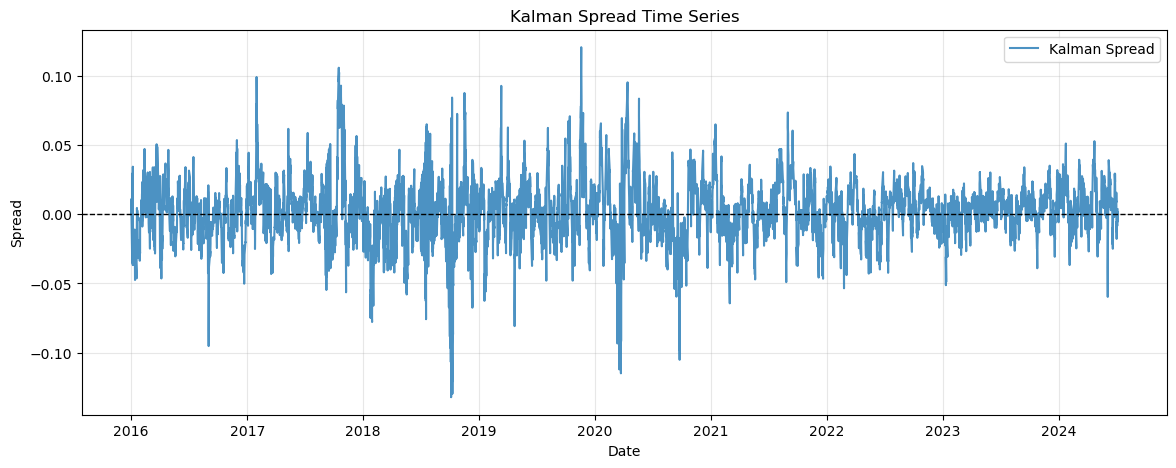

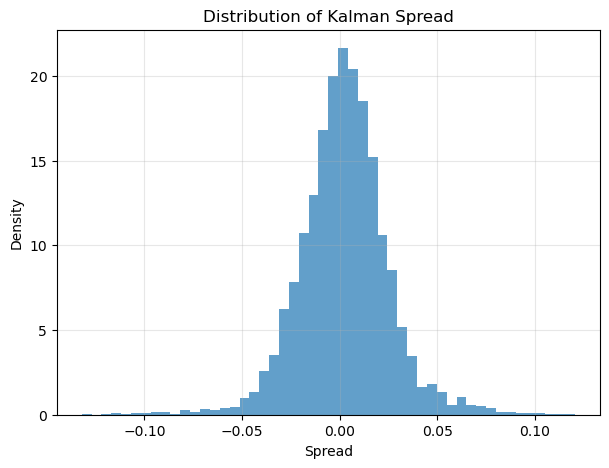

<Figure size 1000x400 with 0 Axes>

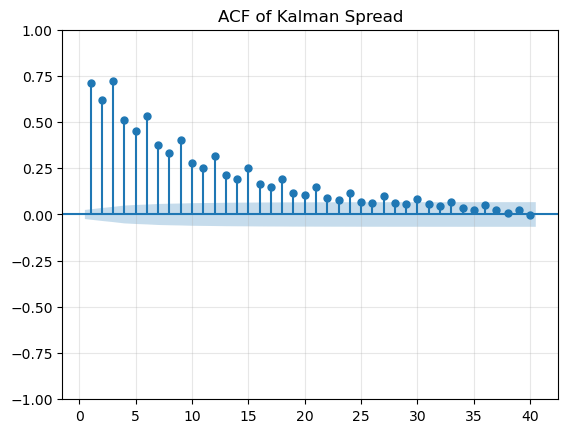

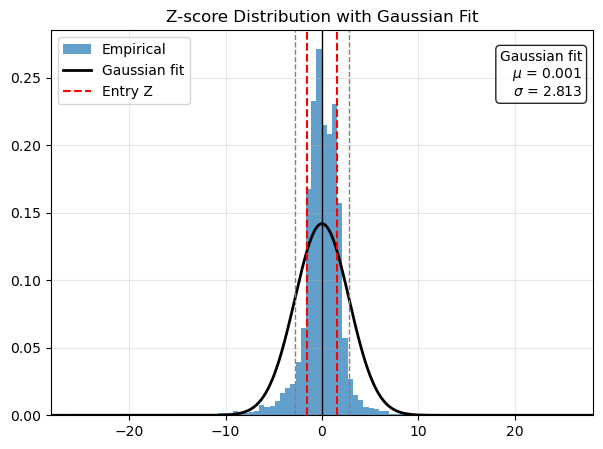

Gaussian Z-score diagnostics
----------------------------
Mean (μ)   : 0.0010
Std (σ)    : 2.8127
Entry Z    : ±1.6
Effective Entry (σ-scaled): ±4.50


In [25]:
plot_kalman_diagnostics(df)


In [27]:
df["cum_return"] = df["strategy_return"].cumsum()
plot_equity_and_drawdown(df,date_col="Date",cumret_col="cum_return")


KeyError: 'strategy_return'